In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate2d
from cv2 import imread, IMREAD_GRAYSCALE

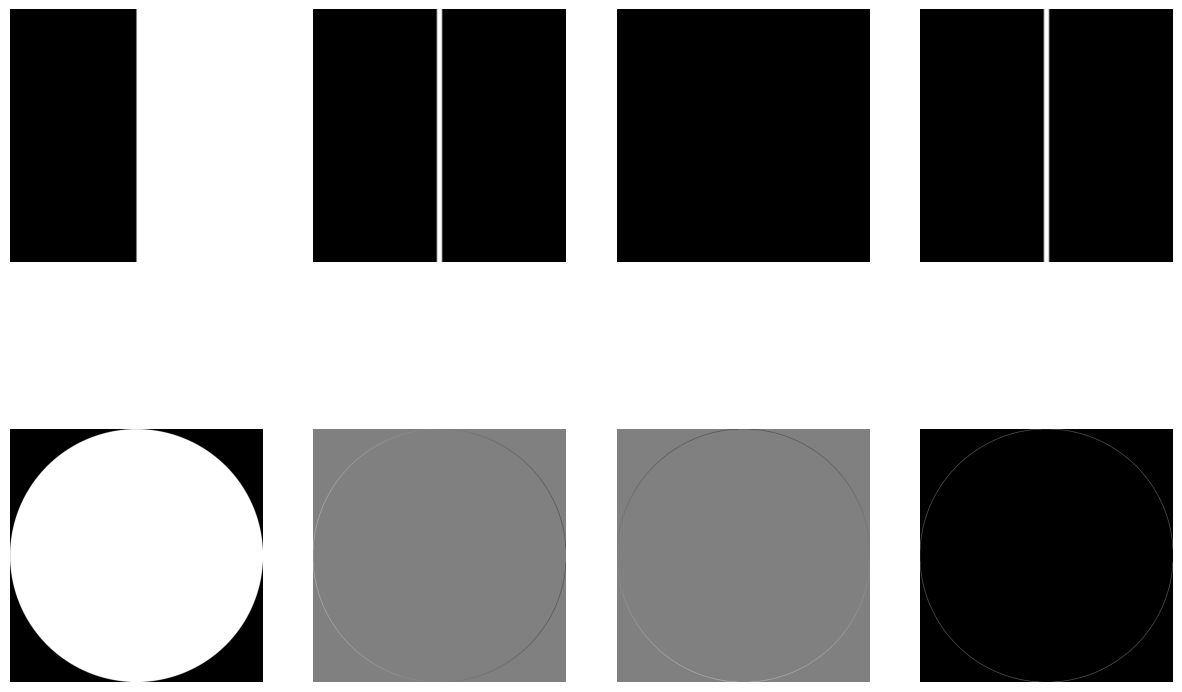

In [ ]:
test1 = np.zeros((100,100),np.uint8)
test1[:,test1.shape[0]//2:] = 1
n = 2000
r = n // 2
y, x = np.ogrid[:n, :n]
test2 = ((x - r)**2 + (y - r)**2 <= r**2).astype(np.uint8)

# other derivation methods:

# gx = [[0,-1,1]]
# gy = [[1],[-1],[0]]
# or 
# gx = [[-.5,0,.5]]
# gy = [[.5],[0],[-.5]]

gx = [[-1,0,1],
      [-2,0,2],
      [-1,0,1]]
gy = [[1,2,1],
      [0,0,0],
      [-1,-2,-1]]

edge_h1 = correlate2d(test1, gx, 'valid')
edge_h2 = correlate2d(test2, gx, 'valid')
edge_v1 = correlate2d(test1, gy, 'valid')
edge_v2 = correlate2d(test2, gy, 'valid')
edge1 = np.sqrt(edge_h1**2 + edge_v1**2)
edge2 = np.sqrt(edge_h2**2 + edge_v2**2)

# a more efficient norm for computing magnitude:

# edge1 = np.abs(edge_h1) + np.abs(edge_v1)
# edge2 = np.abs(edge_h2) + np.abs(edge_v2)

_, ((ax1, ax2, ax3, ax4),
    (ax5, ax6, ax7, ax8)) = plt.subplots(2,4, figsize=(15,10))
ax1.axis('off')
ax1.imshow(test1,'gray')
ax2.axis('off')
ax2.imshow(edge_h1,'gray')
ax3.axis('off')
ax3.imshow(edge_v1,'gray')
ax4.axis('off')
ax4.imshow(edge1,'gray')
ax5.axis('off')
ax5.imshow(test2,'gray')
ax6.axis('off')
ax6.imshow(edge_h2,'gray')
ax7.axis('off')
ax7.imshow(edge_v2,'gray')
ax8.axis('off')
ax8.imshow(edge2,'gray')
plt.show()

### further optimizations:
- > convolve image and derivative of gaussian distribution to save us some extra calculations(instead of taking derivative of the convolved image)

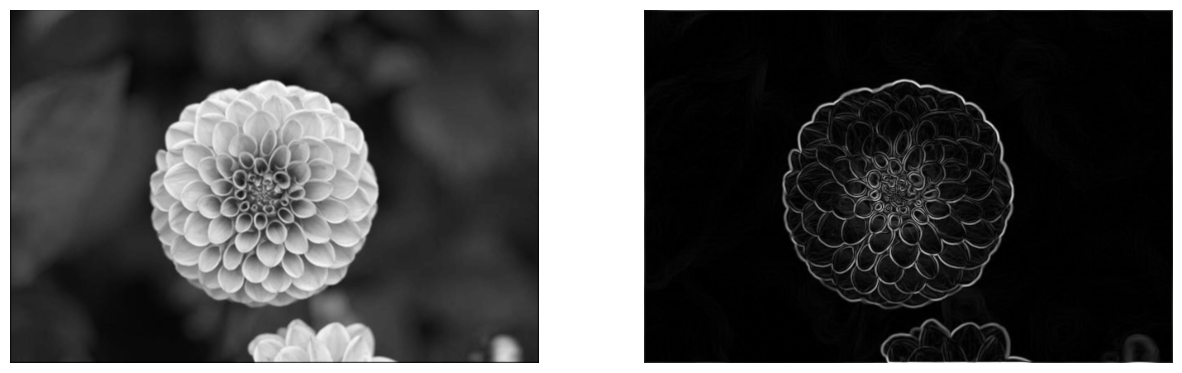

In [3]:
image = imread('flower.jpg', IMREAD_GRAYSCALE)
image = correlate2d(image, np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]])/16) # Smooth the image
gx_image = correlate2d(image, gx, 'valid')
gy_image = correlate2d(image, gy, 'valid')
g_magnitude = np.sqrt(gx_image**2 + gy_image**2)
g_angle = np.arctan2(gy_image, gx_image)

_, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.axis('off')
ax1.imshow(image, 'gray')
ax2.axis('off')
ax2.imshow(g_magnitude, 'gray')

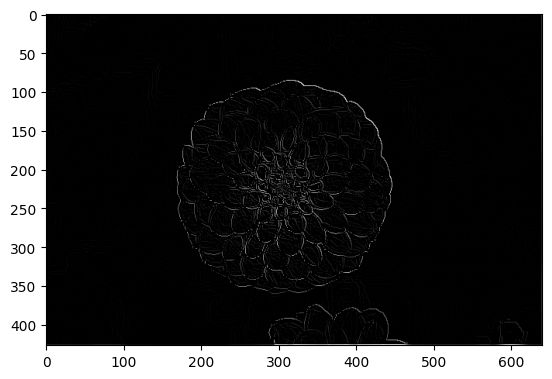

In [29]:
nms = np.copy(g_magnitude)
rows, cols = g_magnitude.shape

for i in range(1, rows - 1):
    for j in range(1, cols - 1):
        angle = g_angle[i,j]
        q = [0, 0]
        if (-np.pi/8 <= angle < np.pi/8) or (7*np.pi/8 <= angle):
            q[0] = g_magnitude[i,j+1]
            q[1] = g_magnitude[i,j-1]
        elif (np.pi/8 <= angle < 3*np.pi/8):
            q[0] = g_magnitude[i+1,j+1]
            q[1] = g_magnitude[i-1,j-1]
        elif (3*np.pi/8 <= angle < 5*np.pi/8):
            q[0] = g_magnitude[i+1,j]
            q[1] = g_magnitude[i-1,j]
        else:
            q[0] = g_magnitude[i-1,j+1]
            q[1] = g_magnitude[i+1,j-1]
        
        if g_magnitude[i,j] < max(q[0], q[1]):
            nms[i,j] = 0

plt.imshow(nms,'gray')
plt.show()

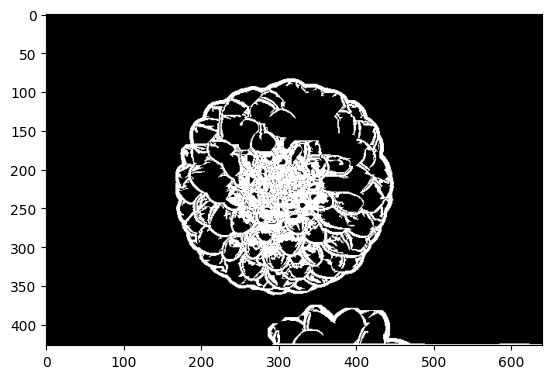

In [40]:
l = 40
h = 300

rows, cols = g_magnitude.shape
edge_map = np.zeros((rows, cols), dtype=np.uint8)

strong_edges = np.where(g_magnitude >= h)
weak_edges = np.argwhere((g_magnitude >= l) & (g_magnitude < h))

edge_map[strong_edges] = 255

for i, j in weak_edges:
    if np.any(edge_map[i-1:i+2, j-1:j+2] == 255):
        edge_map[i, j] = 255

plt.imshow(edge_map,'gray')